**종속성 설치**

In [1]:
pip install transformers peft accelerate optimum bitsandbytes trl wandb einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

라이브러리 및 모듈 임포트

In [2]:
import os
from dataclasses import dataclass, field
from typing import Optional
import re

import torch
import tyro
from accelerate import Accelerator
from datasets import load_dataset, Dataset
from peft import AutoPeftModelForCausalLM, LoraConfig
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

from trl import SFTTrainer

from trl.trainer import ConstantLengthDataset

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


매개변수 설정

In [5]:
@dataclass
class ScriptArguments:
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "the cache dir"}
    )
    model_name: Optional[str] = field(
        default="meta-llama/Llama-2-7b-chat-hf", metadata={"help": "the model name"}
    )

    dataset_name: Optional[str] = field(
        default=None,
        metadata={"help": "the dataset name"},
    )
    seq_length: Optional[int] = field(
        default=1024, metadata={"help": "the sequence length"}
    )
    num_workers: Optional[int] = field(
        default=8, metadata={"help": "the number of workers"}
    )
    training_args: TrainingArguments = field(
        default_factory=lambda: TrainingArguments(
            output_dir="./results",
            # max_steps=500,
            logging_steps=20,
            # save_steps=10,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=2,
            gradient_checkpointing=False,
            group_by_length=False,
            learning_rate=1e-4,
            lr_scheduler_type="cosine",
            # warmup_steps=100,
            warmup_ratio=0.03,
            max_grad_norm=0.3,
            weight_decay=0.05,
            save_total_limit=20,
            save_strategy="epoch",
            num_train_epochs=1,
            optim="paged_adamw_32bit",
            fp16=True,
            remove_unused_columns=False,
            report_to="wandb",
        )
    )

    packing: Optional[bool] = field(
        default=True, metadata={"help": "whether to use packing for SFTTrainer"}
    )

    peft_config: LoraConfig = field(
        default_factory=lambda: LoraConfig(
            r=8,
            lora_alpha=16,
            lora_dropout=0.05,
            target_modules=["c_attn", "c_proj", "c_fc"],
            bias="none",
            task_type="CAUSAL_LM",
        )
    )

    merge_with_final_checkpoint: Optional[bool] = field(
        default=False, metadata={"help": "Do only merge with final checkpoint"}
    )

# 유틸리티

In [6]:
def chars_token_ratio(dataset, tokenizer, nb_examples=400):
    """
    Estimate the average number of characters per token in the dataset.
    """
    total_characters, total_tokens = 0, 0
    for _, example in tqdm(zip(range(nb_examples), iter(dataset)), total=nb_examples):
        text = prepare_sample_text(example)
        total_characters += len(text)
        if tokenizer.is_fast:
            total_tokens += len(tokenizer(text).tokens())
        else:
            total_tokens += len(tokenizer.tokenize(text))

    return total_characters / total_tokens


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# 데이터 로딩

In [7]:
def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""

    prompt_template = """###System;{System}
    ###User;{User}
    ###Midm;{Midm}"""

    default_system_msg = (
        "너는 사용자가 작성한 리뷰의 긍정 또는 부정을 판단해야 한다."
    )

    text = (
        prompt_template.format(System=default_system_msg,
                               User=example["document"],
                               Midm="긍정" if example["label"]==1 else "부정"
                               )
    )

    return text

In [8]:
def create_train_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    train_data = dataset['train'].select(range(5000))

    chars_per_token = chars_token_ratio(train_data, tokenizer)
    print(f"The character to token ratio of the dataset is: {chars_per_token:.2f}")

    train_dataset = ConstantLengthDataset(
        tokenizer,
        train_data,
        formatting_func=prepare_sample_text,
        infinite=True,
        seq_length=args.seq_length,
        chars_per_token=chars_per_token,# 부가정보, 컨트롤하는 정보
    )

    return train_dataset

In [9]:
def create_valid_datasets(tokenizer, args):
    dataset = load_dataset(args.dataset_name, cache_dir=args.cache_dir)
    valid_data = dataset['test']
    valid_dataset = valid_data.select(range(1000))

    return valid_dataset

# 미세 튜닝용 모델 로딩

In [10]:
script_args = ScriptArguments(
    num_workers=2,
    seq_length=256,
    dataset_name='nsmc',
    model_name='KT-AI/midm-bitext-S-7B-inst-v1',
    # model_name='jangmin/midm-7b-safetensors-only',
    )

In [11]:
script_args.training_args.logging_steps = 50
script_args.training_args.max_steps = 800
script_args.training_args.output_dir = '/gdrive/MyDrive/nlp/lora-midm-7b-nsmc-v1.2'
script_args.training_args.run_name = 'midm-7b-nsmc-v1.2'

In [12]:
print(script_args)

ScriptArguments(cache_dir=None, model_name='KT-AI/midm-bitext-S-7B-inst-v1', dataset_name='nsmc', seq_length=256, num_workers=2, training_args=TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=True,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps

In [13]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [14]:
base_model = AutoModelForCausalLM.from_pretrained(
    script_args.model_name,
    quantization_config=bnb_config,
    device_map="auto",  # {"": Accelerator().local_process_index},
    trust_remote_code=True,
    use_auth_token=True,
    cache_dir=script_args.cache_dir,
)
base_model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

configuration_midm.py:   0%|          | 0.00/831 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- configuration_midm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_midm.py:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

rotary_position_embedding.py:   0%|          | 0.00/4.06k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- rotary_position_embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- modeling_midm.py
- rotary_position_embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [15]:
base_model

MidmLMHeadModel(
  (transformer): MidmModel(
    (wte): Embedding(72192, 4096)
    (rotary_pos_emb): RotaryEmbedding()
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x MidmBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MidmAttention(
          (c_attn): Linear4bit(in_features=4096, out_features=12288, bias=False)
          (c_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (mlp): MidmMLP(
          (c_fc): Linear4bit(in_features=4096, out_features=21760, bias=False)
          (c_proj): Linear4bit(in_features=10880, out_features=4096, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  )
 

In [16]:
peft_config = script_args.peft_config

In [17]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=8, target_modules={'c_attn', 'c_fc', 'c_proj'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

In [18]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

tokenizer.add_special_tokens(dict(bos_token='<s>'))

base_model.config.pad_token_id = tokenizer.pad_token_id
base_model.config.bos_token_id = tokenizer.bos_token_id

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

midm_bitext_tokenization.py:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/KT-AI/midm-bitext-S-7B-inst-v1:
- midm_bitext_tokenization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


midm_bitext_tokenizer.model:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

In [19]:
training_args = script_args.training_args

**데이터셋 생성**

In [20]:
train_dataset = create_train_datasets(tokenizer, script_args)
valid_dataset = create_valid_datasets(tokenizer, script_args)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

100%|██████████| 400/400 [00:00<00:00, 5242.86it/s]
/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:548: UserWarning: The passed formatting_func has more than one argument. Usually that function should have a single argument `example` which corresponds to the dictionary returned by each element of the dataset. Make sure you know what you are doing.
  warnings.warn(


The character to token ratio of the dataset is: 1.57


In [21]:
len(train_dataset)

5000

In [22]:
trainer = SFTTrainer(
    model=base_model,
    formatting_func=prepare_sample_text,
    train_dataset=train_dataset,
    eval_dataset=None,
    peft_config=peft_config,
    packing=script_args.packing,
    max_seq_length=script_args.seq_length,
    tokenizer=tokenizer,
    args=training_args,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:267: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [23]:
base_model

MidmLMHeadModel(
  (transformer): MidmModel(
    (wte): Embedding(72192, 4096)
    (rotary_pos_emb): RotaryEmbedding()
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x MidmBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): MidmAttention(
          (c_attn): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096, out_features=12288, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=12288, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (c_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=4096,

In [24]:
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MidmLMHeadModel(
      (transformer): MidmModel(
        (wte): Embedding(72192, 4096)
        (rotary_pos_emb): RotaryEmbedding()
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-31): 32 x MidmBlock(
            (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (attn): MidmAttention(
              (c_attn): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=12288, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=12288, bias=False)
                )
                (lora_embedding_A): ParameterDict()
         

In [25]:
print_trainable_parameters(base_model)

trainable params: 16744448 || all params: 3821510656 || trainable%: 0.4381630592527648


In [26]:
base_model.get_memory_footprint()

7795015808

In [27]:
trainer.model.print_trainable_parameters()

trainable params: 16,744,448 || all params: 7,034,347,520 || trainable%: 0.23803839591934178


시퀀스 길이 384로 진행할 경우 메모리 오버플로우가 발생하여 시퀀스 길이를 256으로 하향조정함

In [28]:
!pip install wandb
import wandb


In [29]:
wandb.init(project="hw-midm", entity="meaningfulokdol")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/utils.py:570: UserWarning: The dataset reached end and the iterator is reset to the start.
  warnings.warn("The dataset reached end and the iterator is reset to the start.")


TrainOutput(global_step=800, training_loss=1.0929430866241454, metrics={'train_runtime': 2003.4806, 'train_samples_per_second': 0.799, 'train_steps_per_second': 0.399, 'total_flos': 1.65609039986688e+16, 'train_loss': 1.0929430866241454, 'epoch': 0.32})

In [31]:
script_args.training_args.output_dir

'/gdrive/MyDrive/nlp/lora-midm-7b-nsmc-v1.2'

In [32]:
trainer.save_model(script_args.training_args.output_dir)

# 추론 테스트

In [33]:
from transformers import pipeline, TextStreamer

In [34]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
        "너는 먼저 사용자가 작성한 영화 리뷰의 감정을 분석하는 에이전트이다. 이로부터 주어진 영화 리뷰에 대한 긍정 또는 부정을 추출해야 한다."
)

In [35]:
def wrapper_generate(model, input_prompt, do_stream=False):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            #input_ids=input_ids.cuda(),
            input_ids = input_ids.to('cuda'),
            streamer=streamer if do_stream else None,
            use_cache=True,
            max_new_tokens=float('inf'),
            do_sample=False
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    decoded_text = decoded_text[0].replace("<[!newline]>", "\n")
    return (decoded_text[len(input_prompt):])

In [ ]:
eval_dic = {i:wrapper_generate(model=base_model, input_prompt=prompt_template.format(System=default_system_msg, User=evaluation_queries[i]))for i, query in enumerate(evaluation_queries)}

미세튜닝된 모델 테스트

In [38]:
from transformers import pipeline, TextStreamer

프롬프트 정의

In [39]:
instruction_prompt_template = """###System;다음은 네이버 영화 리뷰들을 모아놓은 문장이다. 이를 분석하여 사용자가 작성한 영화 리뷰의 감정을 긍정 또는 부정으로 예측하라.

### 리뷰 내용: {0} ### 분석 결과:
"""

prompt_template = """###System;{System}
###User;{User}
###Midm;"""

default_system_msg = (
        "너는 사용자가 작성한 리뷰의 긍정 또는 부정을 판단해야 한다."
)

사용자 영화 리뷰에 대한 입력 프롬프트 생성

In [40]:
def wrapper_generate(model, input_prompt, do_stream=False):
    data = tokenizer(input_prompt, return_tensors="pt")
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    input_ids = data.input_ids[..., :-1]
    with torch.no_grad():
        pred = model.generate(
            input_ids=input_ids.cuda(),
            streamer=streamer if do_stream else None,
            use_cache=True,
            max_new_tokens=float('inf'),
            do_sample=False
        )
    decoded_text = tokenizer.batch_decode(pred, skip_special_tokens=True)
    decoded_text = decoded_text[0].replace("<[!newline]>", "\n")
    return (decoded_text[len(input_prompt):])

양자화 설정: 4비트로 양자화함

In [41]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

미세튜닝된 모델을 4비트로 양자화함

In [42]:
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    script_args.training_args.output_dir,
    quantization_config=bnb_config,
    device_map="auto",
    cache_dir=script_args.cache_dir,
    trust_remote_code=True,
)

ValueError: ignored

토크나이저 초기화


In [54]:
tokenizer = AutoTokenizer.from_pretrained(
    script_args.model_name,
    trust_remote_code=True,
    cache_dir=script_args.cache_dir,
)

if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

tokenizer.add_special_tokens(dict(bos_token='<s>'))

trained_model.config.pad_token_id = tokenizer.pad_token_id
trained_model.config.bos_token_id = tokenizer.bos_token_id

NameError: ignored

데이터셋 생성

In [ ]:
valid_dataset = create_valid_datasets(tokenizer, script_args)

In [ ]:
eval_dic = {i: wrapper_generate(model=trained_model, input_prompt=prompt_template.format(System=default_system_msg, User=example["document"]))for i, example in enumerate(valid_dataset)}

모델 결과

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

true_labels = [example["label"] for example in valid_dataset]

predicted_labels = [1 if "긍정" in eval_dic[i] else 0 for i in range(len(valid_dataset))]

conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1, "\n")

# 분류 리포트 출력
class_report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print("Classification Report:\n", class_report)

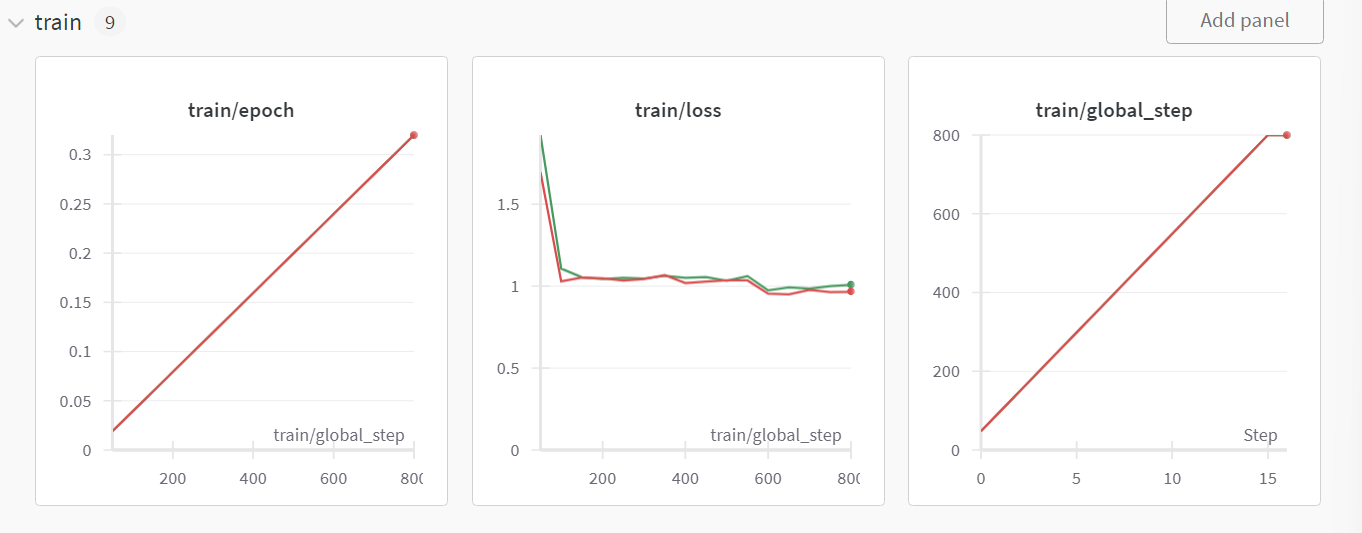

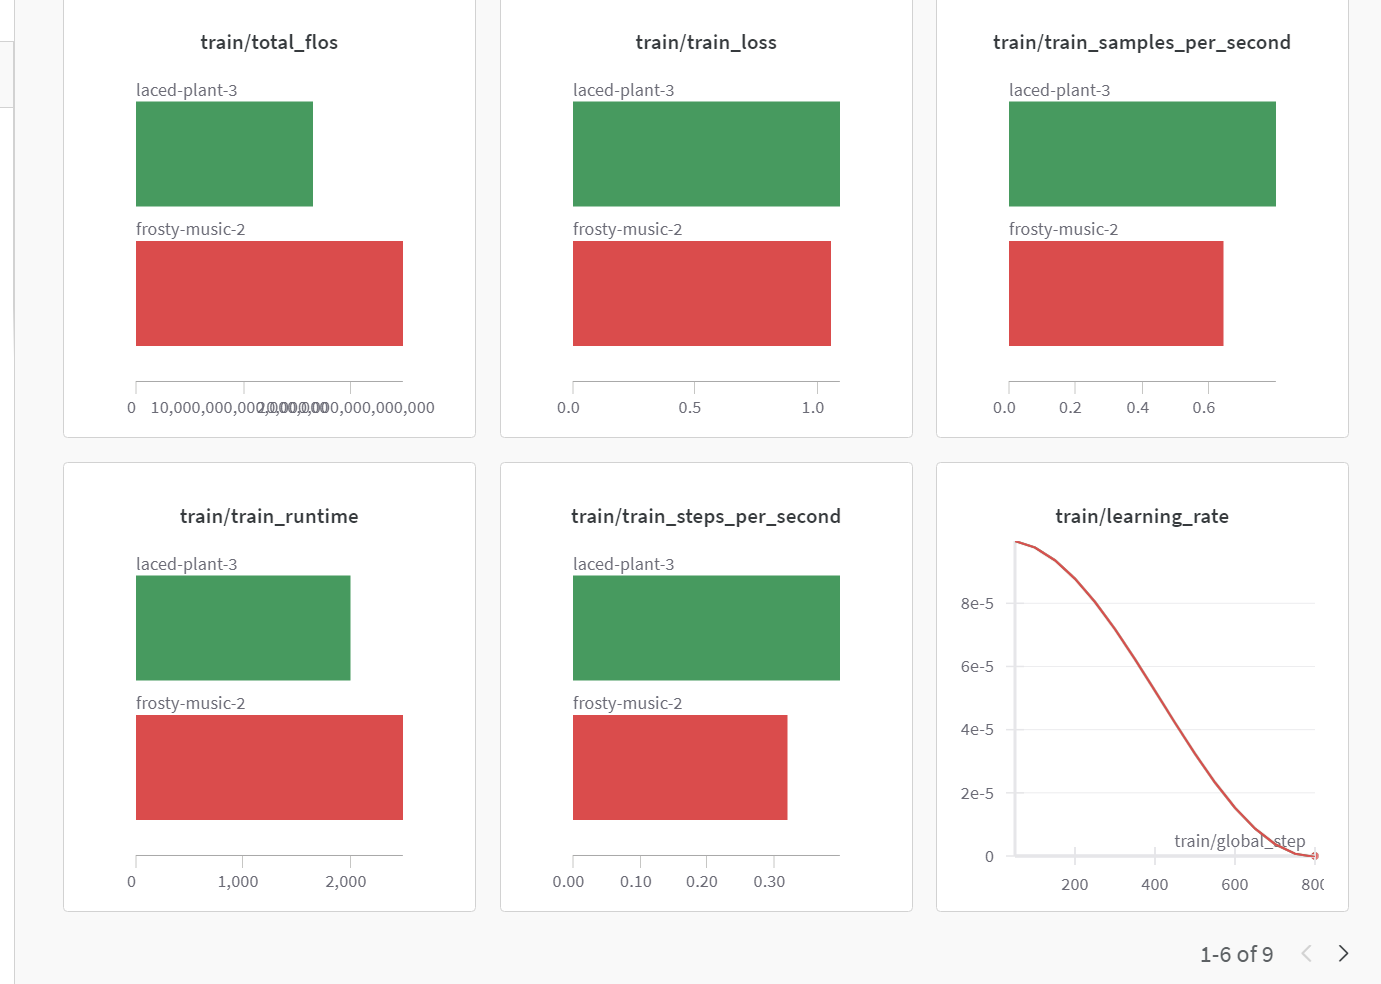

In [4]:
!pip install --upgrade huggingface_hub


In [7]:
from huggingface_hub import Repository
import os

notebook_file = "okdol/hw-midm-7B-nsmc.ipynb"
repo_name = "okdol/hw-midm-7B-nsmc"
repo_url = f"https://huggingface.co/okdol/hw-midm-7B-nsmc"


# 로컬에 리포지토리 디렉토리 생성
os.makedirs(repo_name, exist_ok=True)

# 리포지토리 초기화
repo = Repository(local_dir=repo_name, clone_from=repo_url)

# 노트북 파일을 리포지토리 디렉토리로 복사
notebook_path_in_repo = os.path.join(repo_name, os.path.basename(notebook_file))
os.replace(notebook_file, notebook_path_in_repo)

# Hugging Face Hub에 푸시
repo.push_to_hub()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/okdol/hw-midm-7B-nsmc is already a clone of https://huggingface.co/okdol/hw-midm-7B-nsmc. Make sure you pull the latest changes with `repo.git_pull()`.


FileNotFoundError: ignored